In [1]:
import matplotlib.pyplot as plt
textwidth = 15
figheight = 0.25*textwidth
plt.rcParams["figure.figsize"] = (0.66*textwidth,figheight)
plt.rcParams['text.latex.unicode']=True
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('grid', linestyle="--")
plt.rc('grid', alpha="0.5")
plt.rc('axes', grid=True)

import numpy as np
import re

!mkdir fig

def xaxis_mpi():
    #plt.xscale('log',basex=2)
    plt.gca().set_xticks([1,2,4,8,16,32,64])
    plt.xlim([1,64])
    plt.xlabel("Nombre de processus MPI")
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

mkdir: impossible de créer le répertoire « fig »: Le fichier existe


#### Parse timers

In [2]:
!find data/ -name stdout_optidis_* -exec bash -c "grep 'Timer' {} /dev/null | tail -n 17" \; > data/last_timers.txt

In [3]:
filename_regex = ".*stdout_optidis_p(\d*)_s(\d*)_h(\d*)\.1\.(\d*):"
t_last={}
t_total={}
for line in open("data/last_timers.txt"):
    nb_proc,size,tree_h,rank,name,t_last_,t_total_ = re.match(filename_regex+"Timer : (\S*)\s*Last :\s*(\d*.\d*) ms   Total :\s*(\d*.\d*) s", line).groups()
    nb_proc = int(nb_proc)
    rank = int(rank)
    size = int(size)
    tree_h = int(tree_h)
    t_last[nb_proc,rank,name,size,tree_h] = float(t_last_)
    t_total[nb_proc,rank,name,size,tree_h] = float(t_total_)
    
list_nb_procs = sorted([a for a in set([ p for (p,r,n,s,h) in t_total.keys() ])])
list_rank = sorted([a for a in set([ r for (p,r,n,s,h) in t_total.keys() ])])
list_size = sorted([a for a in set([ s for (p,r,n,s,h) in t_total.keys() ])])
list_names = sorted([a for a in set([ n for (p,r,n,s,h) in t_total.keys() ])])
list_tree_h = sorted([a for a in set([ h for (p,r,n,s,h) in t_total.keys() ])])

In [4]:
timers_labels={}
for name in list_names : 
    timers_labels[name] = name.translate(str.maketrans({"_":  r"\_"}) )
name_total = 'Global_Step'
timers_labels[name_total] = 'Total'
timers_labels['Autres'] = 'Autres'
timers_labels['Force_internal'] = 'Forces'
timers_labels['Mesh.Migrate'] = 'Migration'
timers_labels['Main_IOoperation'] = 'IO'

#### Parse object count

In [5]:
!find data/ -name stdout_optidis_* -exec bash -c "grep 'Nodes :' {} /dev/null | tail -n 1" \; > data/total_count.txt
!find data/ -name stdout_optidis_* -exec bash -c "grep 'Nodes (local) :' {} /dev/null | tail -n 1" \; > data/local_count.txt

In [6]:
nodes_count_total={}
for line in open("data/total_count.txt"):
    nb_proc,size,tree_h,rank,nodes_count_,seg_count_ = re.match(filename_regex+"\s*Nodes : (\d*)\s*Segments : (\d*)", line).groups()
    size = int(size)
    nodes_count_ = int(nodes_count_)
    nodes_count_total[size]=nodes_count_    

nodes_count_local={}
for line in open("data/local_count.txt"):
    nb_proc,size,tree_h,rank,nodes_count_,seg_count_ = re.match(filename_regex+"\s*Nodes \(local\) : (\d*)\s*Segments \(local\) : (\d*).*", line).groups()
    nb_proc = int(nb_proc)
    rank = int(rank)
    size = int(size)
    nodes_count_ = int(nodes_count_)
    nodes_count_local[nb_proc, rank, size]=nodes_count_  


### Détection de la terminaison

In [7]:
!find data -name stdout_optidis_p*.0 -exec bash -c "echo -n {}:; tail -n1 {}" \; > data/last_lines.txt
!find data -name stdout_optidis_p*.00 -exec bash -c "echo -n {}:; tail -n1 {}" \; >> data/last_lines.txt

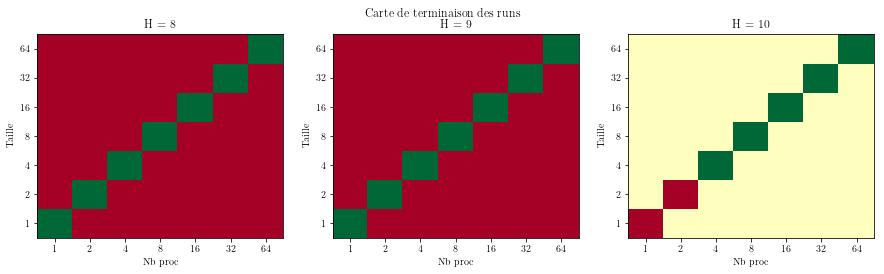

In [8]:
terminated={}
for line in open("data/last_lines.txt"):
    nb_proc,size,tree_h,rank,last_line = re.match(filename_regex+"(.*)\s*", line).groups()
    terminated_ = (last_line == "###			Post processing ...			###")
    terminated[int(nb_proc),int(size),int(tree_h)]=terminated_
    
def terminated_value(i,j,h) :
    val = terminated.get((list_nb_procs[i], list_size[j], h), 123)
    if val == 123 : return 0
    elif val == False : return -1
    elif val == True : return 1
    
plt.figure(figsize=(textwidth, figheight))
i=1
for tree_h in list_tree_h :
    plt.subplot(1,len(list_tree_h),i)
    terminated_map = [[ terminated_value(i,j,tree_h) for i in range(len(list_nb_procs)) ] for j in range(len(list_size))]
    plt.pcolormesh(terminated_map,cmap='RdYlGn')
    plt.title("H = "+str(tree_h))
    plt.xlabel("Nb proc")
    plt.ylabel("Taille")
    ticks = np.arange(7)+0.5
    ax = plt.gca()
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(list_nb_procs)
    ax.set_yticklabels(list_size)
    i=i+1
plt.suptitle("Carte de terminaison des runs")
plt.show()

# Benchmark

## Weak scaling

### Nombre d'objets

In [9]:
#Extract weak scaling counts
total_nodes_count_weak = np.array([ nodes_count_total[p] for p in list_nb_procs ])
local_node_count_max_weak = np.array([ max([ nodes_count_local[p,rank,p] for rank in range(p) ]) for p in list_nb_procs ])
local_node_count_min_weak = np.array([ min([ nodes_count_local[p,rank,p] for rank in range(p) ]) for p in list_nb_procs ])

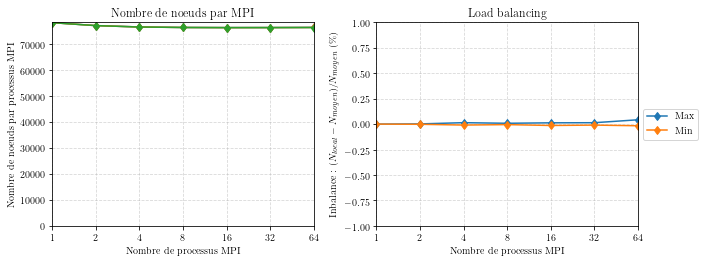

In [10]:
plt.figure(figsize=(0.66*textwidth, figheight))
plt.subplot(121)
plt.plot( list_nb_procs, local_node_count_max_weak    , "d-", label='Max' )
plt.plot( list_nb_procs, total_nodes_count_weak/list_nb_procs, "d-", label='Moyenne' )
plt.plot( list_nb_procs, local_node_count_min_weak     , "d-", label='Min' )
plt.title("Nombre de noeuds par MPI")
plt.ylabel("Nombre de noeuds par processus MPI")
plt.ylim(0)
plt.xscale('log',basex=2)
xaxis_mpi()


plt.subplot(122)
plt.plot( list_nb_procs, 100*((local_node_count_max_weak*list_nb_procs)-total_nodes_count_weak)/total_nodes_count_weak    , "d-", label='Max' )
plt.plot( list_nb_procs, 100*((local_node_count_min_weak*list_nb_procs)-total_nodes_count_weak)/total_nodes_count_weak     , "d-", label='Min' )
plt.title("Load balancing")
plt.ylabel("Inbalance : $(N_{local}-N_{moyen})/N_{moyen}$ (\%)")
plt.xscale('log',basex=2)
plt.ylim([-1,1])
xaxis_mpi()

plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.tight_layout()
plt.show()


### Temps

Ce sont les temps d'execution pour 100 itérations de PrismaticGlide 

In [11]:
#Extract weak scaling times
ts_total_max_weak={}
ts_total_min_weak={}
ts_total_best_weak={}
for name in list_names:
    for h in list_tree_h:
        ts_total_max_weak[name,h] = np.array([ max([ t_total.get( (p,rank,name,p,h) , float('inf') ) for rank in range(p) ]) for p in list_nb_procs ])
        ts_total_min_weak[name,h] = np.array([ min([ t_total.get( (p,rank,name,p,h) , float('inf') )for rank in range(p) ]) for p in list_nb_procs ])
    ts_total_best_weak[name] = np.min( [ ts_total_max_weak[name,h] for h in list_tree_h ] , axis=0)
    print(ts_total_best_weak)
    

{'Collision': array([ 7.268,  8.666, 10.128, 15.176, 20.051, 31.331, 69.836])}
{'Collision': array([ 7.268,  8.666, 10.128, 15.176, 20.051, 31.331, 69.836]), 'Collision.Detect': array([1.27 , 1.235, 1.21 , 1.422, 1.249, 1.251, 1.538])}
{'Collision': array([ 7.268,  8.666, 10.128, 15.176, 20.051, 31.331, 69.836]), 'Collision.Detect': array([1.27 , 1.235, 1.21 , 1.422, 1.249, 1.251, 1.538]), 'Collision.Handle': array([ 0.27 ,  0.195,  0.451,  1.881,  2.941,  4.211, 15.04 ])}
{'Collision': array([ 7.268,  8.666, 10.128, 15.176, 20.051, 31.331, 69.836]), 'Collision.Detect': array([1.27 , 1.235, 1.21 , 1.422, 1.249, 1.251, 1.538]), 'Collision.Handle': array([ 0.27 ,  0.195,  0.451,  1.881,  2.941,  4.211, 15.04 ]), 'Collision.Prepare': array([ 5.469,  7.026,  8.319, 11.62 , 15.668, 25.734, 52.98 ])}
{'Collision': array([ 7.268,  8.666, 10.128, 15.176, 20.051, 31.331, 69.836]), 'Collision.Detect': array([1.27 , 1.235, 1.21 , 1.422, 1.249, 1.251, 1.538]), 'Collision.Handle': array([ 0.27 ,  0

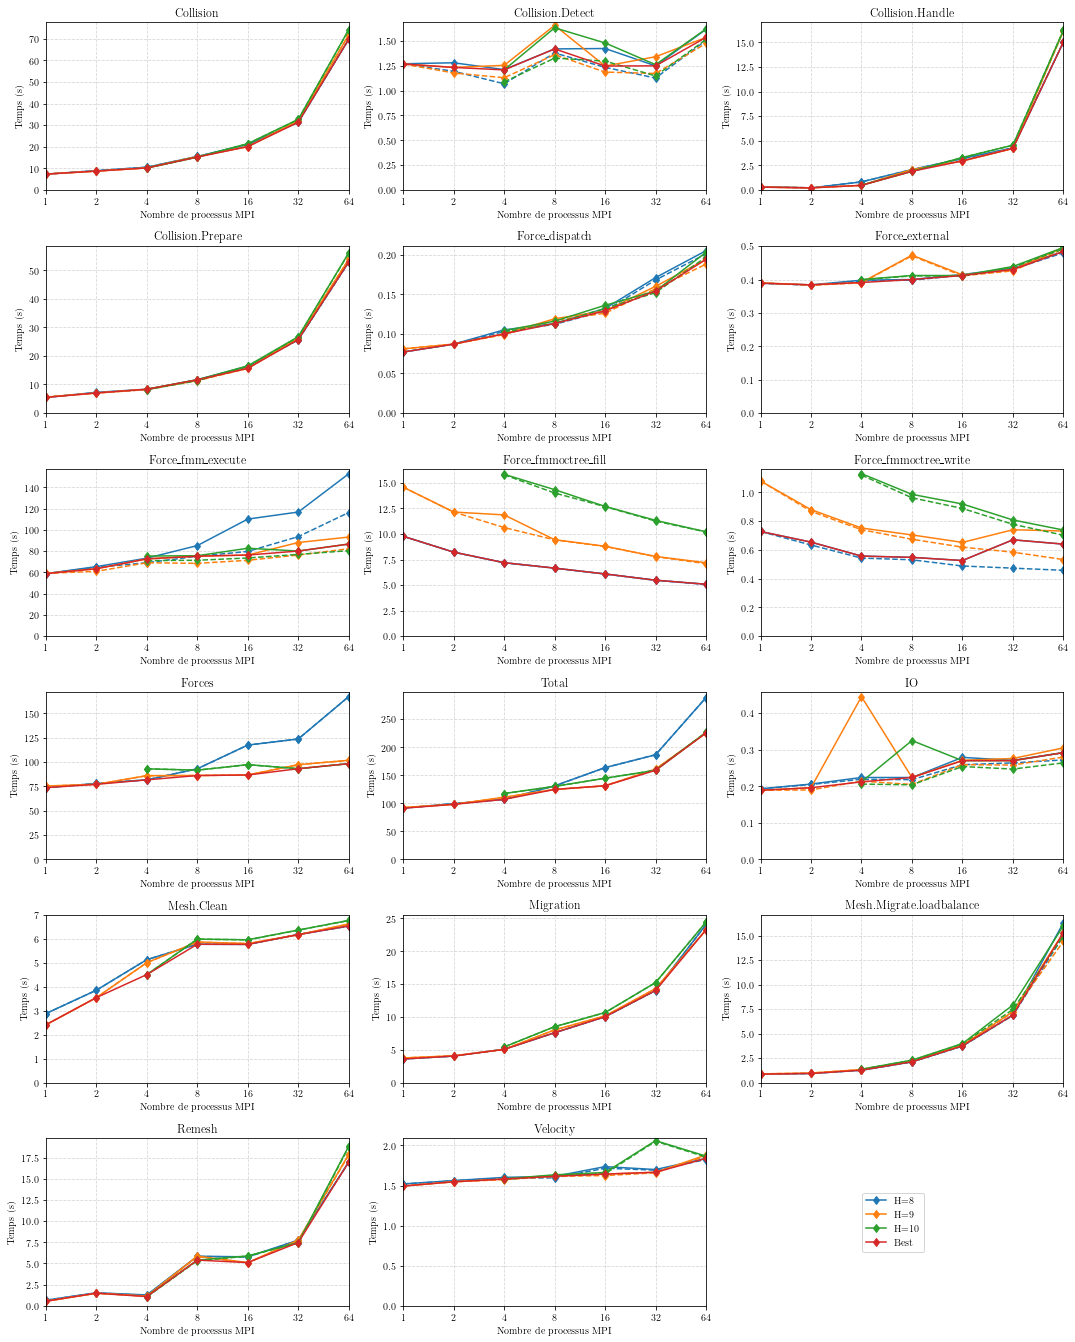

In [12]:
plt.figure(figsize=(textwidth, 5*figheight))
i=1
for name in list_names:
    plt.subplot(6,3,i)
    for h in list_tree_h:
        line, = plt.plot( list_nb_procs, ts_total_max_weak[name,h], 'd-', label="H="+str(h) )
        plt.plot( list_nb_procs, ts_total_min_weak[name,h], 'd--', color=line.get_color() )
    plt.plot( list_nb_procs, ts_total_best_weak[name], 'd-', label="Best" )
    plt.title( timers_labels[name] ) 
    plt.xscale('log',basex=2)
    plt.ylim(0)
    plt.ylabel('Temps (s)')
    xaxis_mpi()
    i=i+1  

plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1.5,0.5))


plt.show()

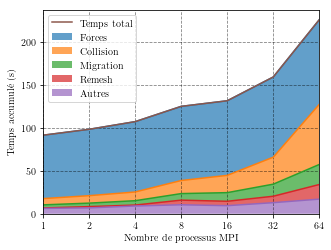

In [13]:
names_to_plot = [ 'Mesh.Migrate', 'Remesh', 'Force_internal', 'Collision' ]
names_to_plot = sorted(names_to_plot, key=lambda n : ts_total_best_weak[n][-1])

times_tot = ts_total_best_weak[name_total]
times=[ ts_total_best_weak[name] for name in names_to_plot ]
times_rem = times_tot - np.sum( times, axis=0 )
times = [np.zeros(len(times[0])),times_rem] + times
times_sum = np.cumsum(times,axis=0)
labels = [ timers_labels[name] for name in ['Autres'] + names_to_plot ]

plt.figure(figsize=(0.33*textwidth, figheight))
for i in range(len(times_sum)-1,0,-1) :
    plt.fill_between(list_nb_procs, times_sum[i-1], times_sum[i], alpha=0.7, label=labels[i-1])
    plt.plot(list_nb_procs, times_sum[i])

plt.plot(list_nb_procs,ts_total_best_weak[name_total], label='Temps total')

#plt.yscale('log')
plt.xscale('log',basex=2)
plt.grid(linestyle="--", color='black')
#plt.ylim([0,200])
plt.ylim(0)
plt.ylabel('Temps accumulé (s)')
xaxis_mpi()
plt.legend()
plt.savefig("fig/bench_mpi_weak_times.pdf", transparent=True, bbox_inches='tight')
plt.show()

 *Figure* - Temps d'éxecution cumulés pour 100 itérations de PrismaticGlide avec ~77 000 segments/processus

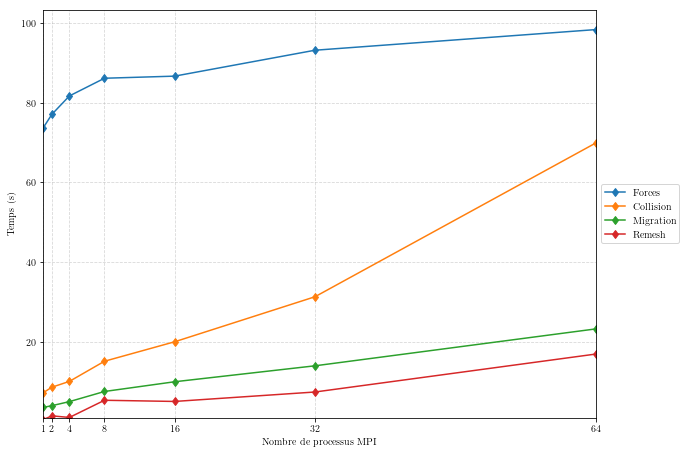

In [14]:
plt.figure(figsize=(0.66*textwidth, 2*figheight))
for name in reversed(names_to_plot):
    line, = plt.plot( list_nb_procs, ts_total_best_weak[name], 'd-', label=timers_labels[name] )
    #plt.plot( list_nb_procs, ts_total_min[name], 'd--', color=line.get_color(), label=name.translate(str.maketrans({"_":  r"\_"}) ) )
#plt.xscale('log',basex=2)
#plt.yscale('log')
plt.ylim(1)
plt.ylabel('Temps (s)')
xaxis_mpi()
plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.show()

 *Figure* - Temps d'éxecution de différentes étapes de la simulation pour 100 itérations de PrismaticGlide avec ~77 000 segments/processus

### Efficacité

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


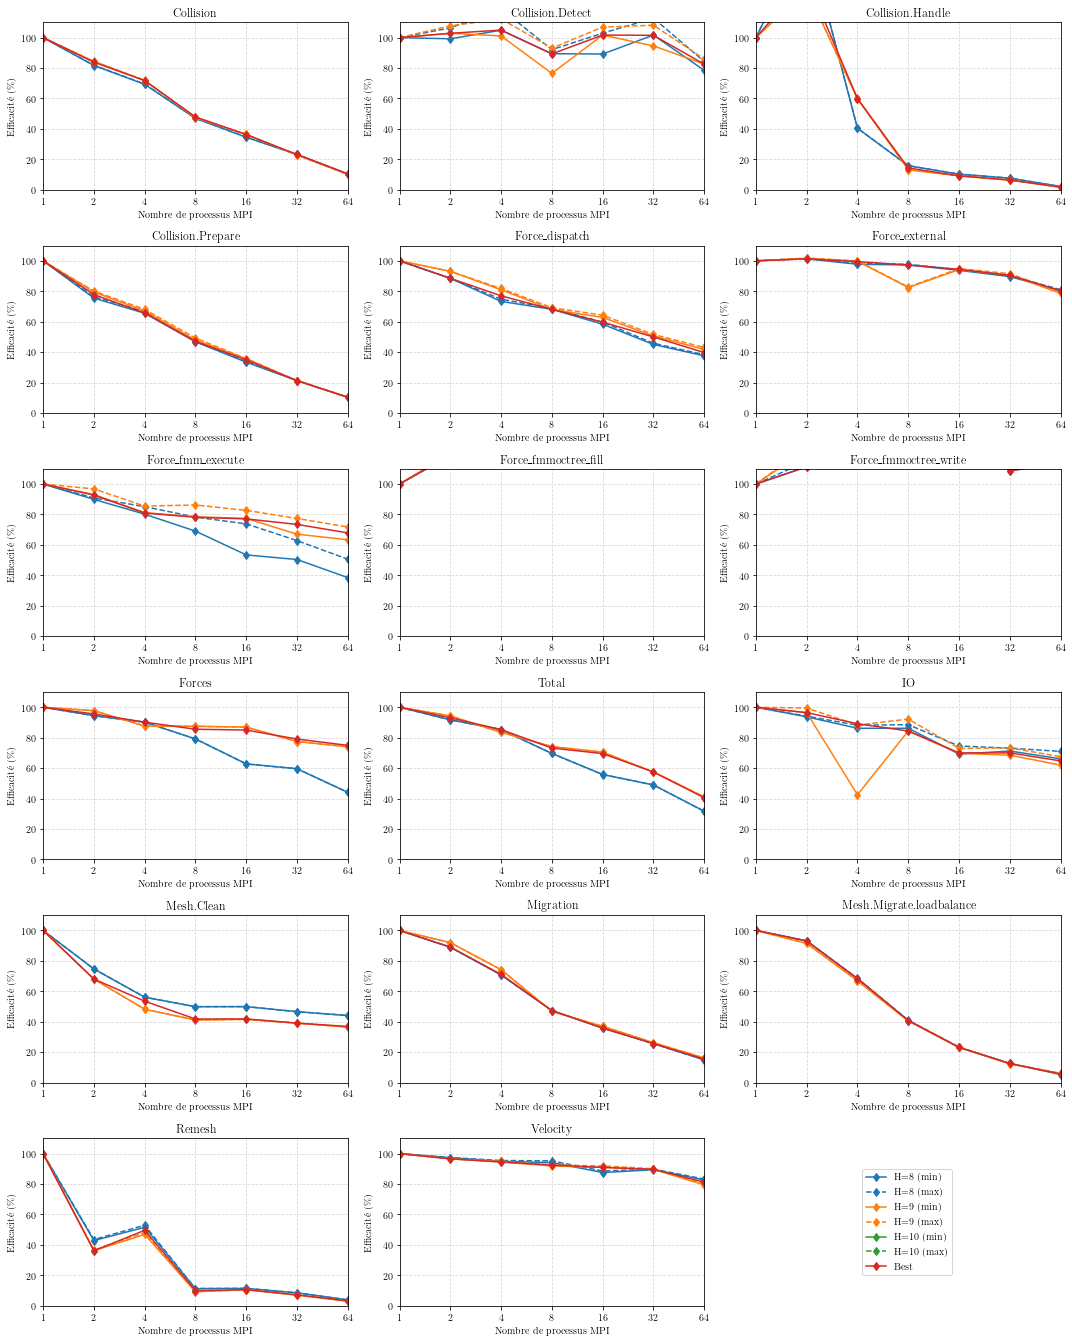

In [15]:
def plot_efficiency_full( name ) :
    for h in list_tree_h:
        line, = plt.plot( list_nb_procs, 100*ts_total_max_weak[name,h][0]/ts_total_max_weak[name,h], 'd-', label="H="+str(h)+" (min)" )
        plt.plot( list_nb_procs, 100*ts_total_min_weak[name,h][0]/ts_total_min_weak[name,h], 'd--', color=line.get_color(), label="H="+str(h)+" (max)" )
    plt.plot( list_nb_procs, 100*ts_total_best_weak[name][0]/ts_total_best_weak[name], 'd-', label="Best" )

    plt.ylabel( 'Efficacité (\%)' )
    plt.xscale('log',basex=2)
    xaxis_mpi()
    plt.ylim([0,110])

def plot_efficiency( name ) :
    label = timers_labels[name];
    plt.plot( list_nb_procs, 100*ts_total_best_weak[name][0]/ts_total_best_weak[name], 'd-', label=label )
    plt.ylabel( 'Efficacité (\%)' )
    plt.xscale('log',basex=2)
    xaxis_mpi()
    plt.ylim([0,110])
    

plt.figure(figsize=(textwidth, 5*figheight))
i=1
for name in list_names:
    plt.subplot(6,3,i)
    plt.title( timers_labels[name] )
    plot_efficiency_full(name) 
    i=i+1
plt.tight_layout() 
plt.legend( bbox_to_anchor = (1.5,0.5), loc='center left' )
plt.show()

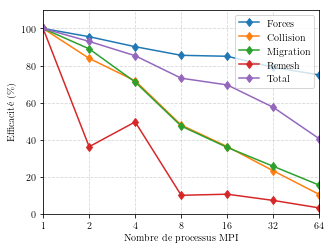

In [16]:
plt.figure(figsize=(0.33*textwidth, figheight))
for name in reversed(names_to_plot):
    plot_efficiency(name)
plot_efficiency(name_total)
plt.legend()
plt.savefig("fig/bench_mpi_weak_eff.pdf", transparent=True, bbox_inches='tight')
plt.show()

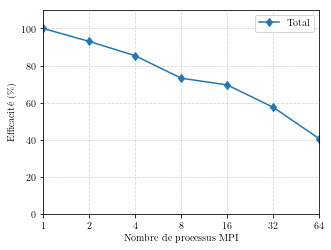

In [17]:
plt.figure(figsize=(0.33*textwidth, figheight))
plot_efficiency(name_total)
plt.legend()
plt.show()

## Strong Scaling

### Load balancing

In [18]:
size_strong=16
total_nodes_count_strong = nodes_count_total[size_strong]
local_node_count_max_strong = np.array([ max([ nodes_count_local[p,rank,size_strong] for rank in range(p) ]) for p in list_nb_procs ])
local_node_count_min_strong = np.array([ min([ nodes_count_local[p,rank,size_strong] for rank in range(p) ]) for p in list_nb_procs ])

KeyError: (1, 0, 16)

In [ ]:
plt.figure(figsize=(0.66*textwidth, figheight))
plt.subplot(121)
plt.plot( list_nb_procs, local_node_count_max_strong    , "d-", label='Max' )
plt.plot( list_nb_procs, total_nodes_count_strong/np.array(list_nb_procs) , "d-", label='Moyenne' )
plt.plot( list_nb_procs, local_node_count_min_strong     , "d-", label='Min' )
plt.title("Nombre de noeuds par MPI")
plt.ylabel("Nombre de noeuds par processus MPI")
plt.yscale('log')
plt.xscale('log',basex=2)
plt.ylim(1)
xaxis_mpi()

plt.subplot(122)
plt.plot( list_nb_procs, 100*((local_node_count_max_strong*list_nb_procs)-total_nodes_count_strong)/total_nodes_count_strong    , "d-", label='Max' )
plt.plot( list_nb_procs, 100*((local_node_count_min_strong*list_nb_procs)-total_nodes_count_strong)/total_nodes_count_strong     , "d-", label='Min' )
plt.title("Load balancing")
plt.ylabel("Différence du nombre de noeuds (\%)")
plt.xscale('log',basex=2)
plt.ylim([-1,1])
xaxis_mpi()

plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.tight_layout()
plt.show()

### Temps

In [ ]:
h_strong=6

#list_nb_procs=[1,2,8,16,32,64]

#Extract strong scaling times
ts_total_max_strong={}
ts_total_min_strong={}
for name in list_names:
    ts_total_max_strong[name] = np.array([ max([ t_total[p,rank,name,size_strong,h_strong] for rank in range(p) ]) for p in list_nb_procs ])
    ts_total_min_strong[name] = np.array([ min([ t_total[p,rank,name,size_strong,h_strong] for rank in range(p) ]) for p in list_nb_procs ])

In [ ]:
plt.figure(figsize=(textwidth, 5*figheight))
i=1
for name in list_names:
    plt.subplot(6,3,i)
    line, = plt.plot( list_nb_procs, ts_total_max_strong[name], 'd-' )
    plt.plot( list_nb_procs, ts_total_min_strong[name], 'd--', color=line.get_color() )
    plt.title( timers_labels[name] ) 
    #plt.xscale('log',basex=2)
    plt.ylim(0)
    plt.ylabel('Temps (s)')
    xaxis_mpi()
    i=i+1  
plt.tight_layout()

plt.show()

In [ ]:
names_to_plot = [ 'Main_IOoperation','Mesh.Migrate', 'Remesh', 'Force_internal', 'Collision' ]
names_to_plot = sorted(names_to_plot, key=lambda n : ts_total_max_strong[n][-1])

times_tot = ts_total_max_strong[name_total]
times=[ ts_total_max_strong[name] for name in names_to_plot ]
times_rem = times_tot - np.sum( times, axis=0 )
times = [np.zeros(len(times[0])),times_rem] + times
times_sum = np.cumsum(times,axis=0)
times_sum = times_sum*list_nb_procs
labels = [ timers_labels[name] for name in ['Autres'] + names_to_plot ]

plt.figure(figsize=(0.33*textwidth, figheight))
for i in range(len(times_sum)-1,0,-1) :
    plt.fill_between(list_nb_procs, times_sum[i-1], times_sum[i], alpha=0.7, label=labels[i-1])
    plt.plot(list_nb_procs, times_sum[i])

plt.plot(list_nb_procs,ts_total_max_strong[name_total]*list_nb_procs, label='Temps total')

#plt.yscale('log')
#plt.xscale('log',basex=2)
plt.grid(linestyle="--", color='black')
#plt.ylim([0,200])
plt.ylim(0)
plt.ylabel('Temps accumulé (Somme des temps MPI) (s)')
xaxis_mpi()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(0.66*textwidth, 2*figheight))
for name in reversed(names_to_plot):
    line, = plt.plot( list_nb_procs, ts_total_max_strong[name], 'd-', label=timers_labels[name] )
    #plt.plot( list_nb_procs, ts_total_min_strong[name], 'd--', color=line.get_color(), label=name.translate(str.maketrans({"_":  r"\_"}) ) )
#plt.xscale('log',basex=2)
#plt.yscale('log')
plt.ylim(1)
plt.ylabel('Temps (s)')
xaxis_mpi()
plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.show()

### Efficacité

In [ ]:
def plot_efficiency_strong( name, plot_max=True, label=None ) :
    if label == None :
        label = timers_labels[name];
    label_min = label
    if plot_max :
        label_min = label_min + ' (min)'
    line, = plt.plot( list_nb_procs, 100*(ts_total_max_strong[name][0]/list_nb_procs)/ts_total_max_strong[name], 'd-', label=label_min )
    if plot_max:
        plt.plot( list_nb_procs, 100*(ts_total_min_strong[name][0]/list_nb_procs)/ts_total_min_strong[name], 'd--', color=line.get_color(), label=label+' (max)' )
    plt.ylabel( 'Efficacité (\%)' )
    plt.xscale('log',basex=2)
    xaxis_mpi()
    plt.ylim([0,110])
    

plt.figure(figsize=(textwidth, 5*figheight))
i=1
for name in list_names:
    plt.subplot(6,3,i)
    plt.title( timers_labels[name] )
    plot_efficiency_strong(name, label="Efficacité")
    if i==2 :
        plt.legend( bbox_to_anchor = (0.5,1.1), loc='lower center' )
    i=i+1
plt.tight_layout()  
plt.show()

In [ ]:
plt.figure(figsize=(0.66*textwidth, figheight))
plt.subplot(121)
for name in reversed(names_to_plot):
    plot_efficiency_strong(name, plot_max=False)
plt.legend()

plt.subplot(122)
plot_efficiency_strong(name_total, plot_max=False)
plt.legend()

plt.show()